In [0]:
!pip install -U tensorflow-gpu

## **1. Installing required libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scipy import io as spio
from keras.layers import Dense
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dropout
from keras.models import Sequential
from sklearn.utils import class_weight
from IPython.display import Image, display
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## **2. Getting Data and Annotations and extracting them**

In [3]:
!wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz      #Pulls the Images from its site
!wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip   #Pulls the annotation file 
!tar -xf mpii_human_pose_v1.tar.gz
!rm -rf mpii_human_pose_v1.tar.gz
!unzip mpii_human_pose_v1_u12_2.zip
!mv /content/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat /content/
!rm -rf sample_data
!rm -rf mpii_human_pose_v1_u12_2
!rm -rf mpii_human_pose_v1_u12_2.zip

--2020-01-25 19:38:10--  https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12088943206 (11G) [application/x-gzip]
Saving to: ‘mpii_human_pose_v1.tar.gz’

mpii_human_pose_v1. 100%[===================>]  11.26G  19.5MB/s    in 10m 1s  

2020-01-25 19:48:13 (19.2 MB/s) - ‘mpii_human_pose_v1.tar.gz’ saved [12088943206/12088943206]

--2020-01-25 19:48:17--  https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12340483 (12M) [application/zip]
Saving to: ‘mpii_human_

## **3. Displaying Sample images**

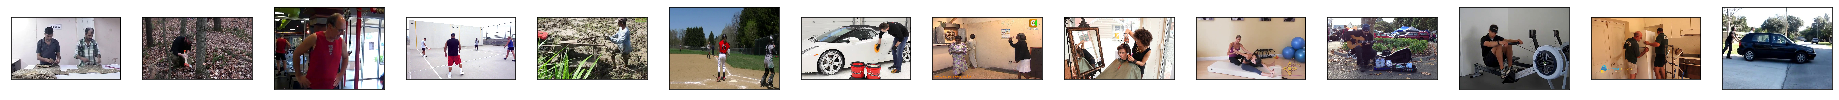

In [0]:
images, dimentions = os.listdir('images'), 1
plt.subplots(figsize=(35,25))
for i in range(3):
  for image in images:
    if dimentions == 15:
      break
    number += 1
    cur_img = mpimg.imread("images/"+image)
    ax = plt.subplot(1, 15, dimentions)
    ax.set_xticks([]), ax.set_yticks([])
    plt.imshow(cur_img)
    dimentions += 1

## **4. Extracting Features**

In [4]:
annots = spio.loadmat('mpii_human_pose_v1_u12_1.mat')
DF = pd.DataFrame(index=range(0,len(annots['RELEASE'][0][0][0][0])),columns=['Image','Category','Activity'])
for i in range(0,len(annots['RELEASE'][0][0][0][0])):
  DF.loc[[i,0],'Image'] = annots["RELEASE"]["annolist"][0,0][0][i]['image']['name'][0, 0][0]
  try: DF.loc[[i,1],'Category'] = annots["RELEASE"]["act"][0,0][:,0][i]["cat_name"][0]
  except Exception: pass
  try: DF.loc[[i,2],'Activity'] = annots["RELEASE"]["act"][0,0][:,0][i]["act_name"][0]
  except Exception: pass
  DF.loc[[i,3],'Train'] = annots["RELEASE"]["img_train"][0,0][0][i]
DF.head()

,Image,Category,Activity,Train
0,053686627.jpg,NaN,NaN,0.0
1,095071431.jpg,transportation,NaN,0.0
2,073199394.jpg,NaN,pushing car,0.0
3,059865848.jpg,NaN,NaN,0.0
4,015601864.jpg,sports,curling,1.0


## **5. Exploring Features**

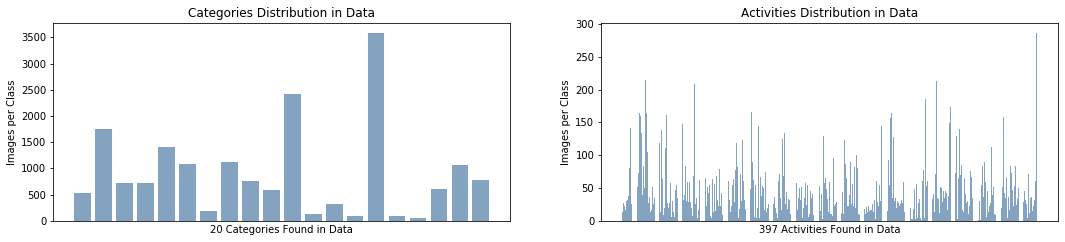

In [0]:
Cat_DF = pd.DataFrame(DF['Category'].value_counts(), columns=['index', 'Category']).sort_index()
Act_DF = pd.DataFrame(DF['Activity'].value_counts(), columns=['index', 'Activity']).sort_index()

plt.figure(1, figsize = (18,8)) 
plt.subplot(221)  
plt.bar(Cat_DF.index, Cat_DF.Category, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks([])
plt.title('Categories Distribution in Data')  
plt.xlabel(str(len(DF['Category'].value_counts())) + ' Categories Found in Data')
plt.ylabel('Images per Class')
    
plt.subplot(222)  
plt.bar(Act_DF.index, Act_DF.Activity, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks([])
plt.title('Activities Distribution in Data')  
plt.xlabel(str(len(DF['Activity'].value_counts())) + ' Activities Found in Data')
plt.ylabel('Images per Class')

plt.show()

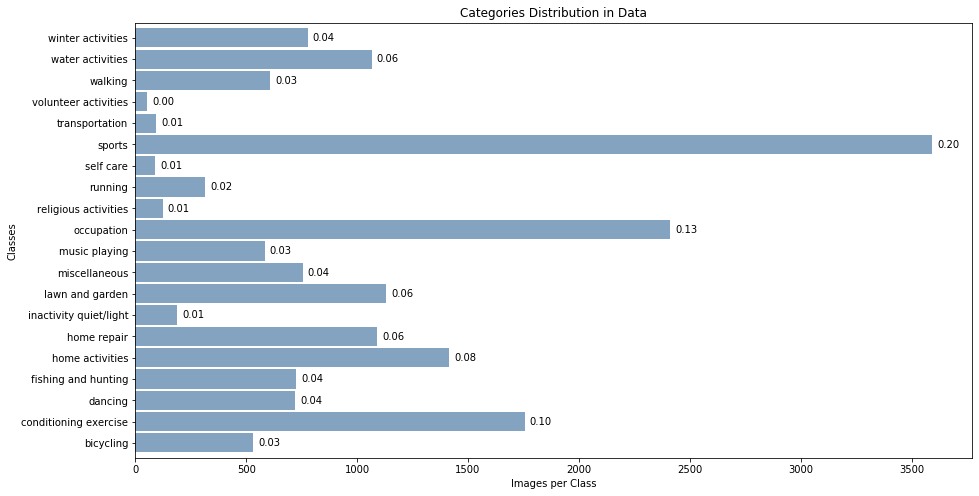

In [0]:
frequencies = DF['Category'].value_counts().sort_index().values
freq_series = pd.Series(frequencies)
y_labels = DF['Category'].value_counts().sort_index().index
plt.figure(1, figsize = (15,8))
ax = freq_series.plot(kind='barh', color=(0.2, 0.4, 0.6, 0.6), width=0.9)
ax.set_title('Categories Distribution in Data')
ax.set_xlabel('Images per Class')
ax.set_ylabel('Classes')
ax.set_yticklabels(y_labels)
rects = ax.patches

for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 5
    ha = 'left'
    label = "{:.2f}".format(x_value/18000)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha) 

# **6. Baseline Model Testing** 

## **VGG16**

### A1 [10 Epochs][50 Batch][Shuffling][-10][+layers] - Training & Validation: [93][73]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=50, class_mode="sparse", target_size=(224,224))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=50, class_mode="sparse", target_size=(224,224))

In [0]:
vgg16 = VGG16(include_top = False, weights='imagenet', pooling='avg', classes=20)
model_vgg = Sequential()
model_vgg.add(vgg16)
model_vgg.add(keras.layers.Flatten())
model_vgg.add(Dense(512, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(20, activation = 'softmax'))

for layer in vgg16.layers[:-10]:
        layer.trainable = False

adam = Adam(lr=0.0001)
model_vgg.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cb_checkpointer_vgg = ModelCheckpoint(filepath = '../best_vgg.h5', monitor = 'val_loss', save_best_only = True)
fit_history = model_vgg.fit(Training, epochs = 10, validation_data=Validation, callbacks=[cb_checkpointer_vgg])

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/10
289/289 [==============================] - 392s 1s/step - loss: 2.2695 - acc: 0.3007 - val_loss: 1.9052 - val_acc: 0.4121
Epoch 2/10
289/289 [==============================] - 354s 1s/step - loss: 1.7523 - acc: 0.4612 - val_loss: 1.5453 - val_acc: 0.5230
Epoch 3/10
289/289 [==============================] - 339s 1s/step - loss: 1.4157 - acc: 0.5626 - val_loss: 1.3455 - val_acc: 0.5776
Epoch 4/10
289/289 [==============================] - 342s 1s/step - loss: 1.1093 - acc: 0.6613 - val_loss: 1.1741 - val_acc: 0.6489
Epoch 5/10
289/289 [==============================] - 339s 1s/step - loss: 0.8570 - acc: 0.7359 - val_loss: 1.0809 - val_acc: 0.6911
Epoch 6/10
289/289 [==============================] - 335s 1s/step - loss: 0.6529 - acc: 0.7962 - val_loss: 1.0589 - val_acc: 0.6966
Epoch 7/10
289/289 [==============================] - 339s 1s/step - loss: 0.4838 - acc: 0.8480 - val_loss: 1.0707 - val_acc: 0.7160
Epoc

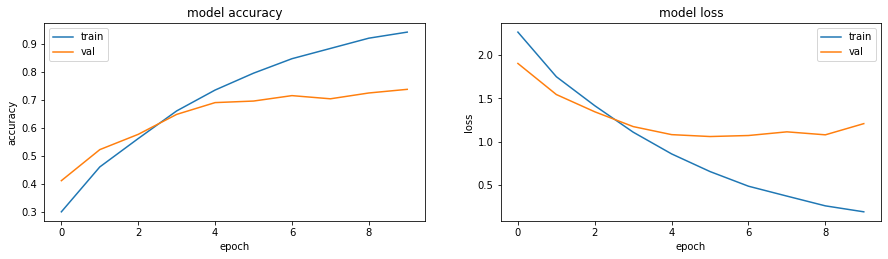

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val']) 

plt.show()

## **InceptionResNetV2**

### A1 [10 Epochs][30 Batch][Shuffling][+layers] - Training & Validation: [93][64]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
NUM_CLASSES = len(Cat_DF)   #class/Labels
inception = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=None,input_shape=[299,299,3], classes=NUM_CLASSES)
Flatten  = keras.layers.Flatten()
Dropout = keras.layers.Dropout(0.5)
Output   = keras.layers.Dense(NUM_CLASSES, activation="softmax")

IRNV2Model = tf.keras.Sequential([ inception, Flatten, Dropout, Output  ])
IRNV2Model.layers[0].trainable = False
IRNV2Model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = IRNV2Model.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)
IRNV2Model.save('IRNV2Model.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 407s 846ms/step - loss: 6.5665 - accuracy: 0.4937 - val_loss: 8.3498 - val_accuracy: 0.5793
Epoch 2/10
481/481 [==============================] - 376s 781ms/step - loss: 2.6987 - accuracy: 0.7565 - val_loss: 7.0263 - val_accuracy: 0.6328
Epoch 3/10
481/481 [==============================] - 364s 756ms/step - loss: 1.7569 - accuracy: 0.8280 - val_loss: 9.5423 - val_accuracy: 0.6267
Epoch 4/10
481/481 [==============================] - 368s 764ms/step - loss: 1.3641 - accuracy: 0.8686 - val_loss: 11.2451 - val_accuracy: 0.6159
Epoch 5/10
481/481 [==============================] - 360s 749ms/step - loss: 1.2465 - accuracy: 0.8839 - val_loss: 11.6598 - val_accuracy: 0.6425
Epoch 6/10
481/481 [==============================] - 358s 744ms/step - loss: 1.2134 - accuracy: 0.8961 - val_loss: 13.8669 - val_accuracy: 0.6045
Epoch 7/10
481/481 [=======

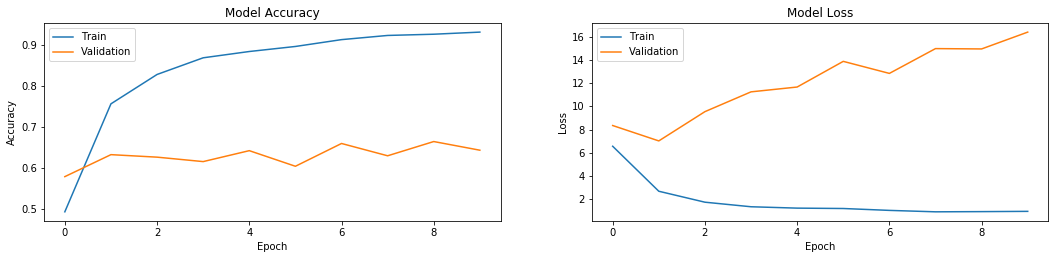

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A2 [10 Epochs][100 Batch][Shuffling][+layers] - Training & Validation: [94][65]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
NUM_CLASSES = len(Cat_DF)   #class/Labels
inception = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=None,input_shape=[299,299,3], classes=NUM_CLASSES)
Flatten  = keras.layers.Flatten()
Dropout = keras.layers.Dropout(0.5)
Output   = keras.layers.Dense(NUM_CLASSES, activation="softmax")

IRNV2Model100 = tf.keras.Sequential([ inception, Flatten, Dropout, Output  ])
IRNV2Model100.layers[0].trainable = False
IRNV2Model100.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = IRNV2Model100.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)
IRNV2Model100.save('IRNV2Model100.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 145 steps, validate for 37 steps
Epoch 1/10
145/145 [==============================] - 372s 3s/step - loss: 6.5240 - accuracy: 0.4905 - val_loss: 3.4959 - val_accuracy: 0.6403
Epoch 2/10
145/145 [==============================] - 356s 2s/step - loss: 1.2604 - accuracy: 0.7656 - val_loss: 3.7252 - val_accuracy: 0.6303
Epoch 3/10
145/145 [==============================] - 352s 2s/step - loss: 0.8050 - accuracy: 0.8423 - val_loss: 4.3633 - val_accuracy: 0.6298
Epoch 4/10
145/145 [==============================] - 349s 2s/step - loss: 0.5316 - accuracy: 0.8913 - val_loss: 5.0613 - val_accuracy: 0.6217
Epoch 5/10
145/145 [==============================] - 350s 2s/step - loss: 0.5350 - accuracy: 0.8955 - val_loss: 4.7135 - val_accuracy: 0.6603
Epoch 6/10
145/145 [==============================] - 348s 2s/step - loss: 0.3208 - accuracy: 0.9332 - val_loss: 5.5918 - val_accuracy: 0.6400
Epoch 7/10
145/145 [=============================

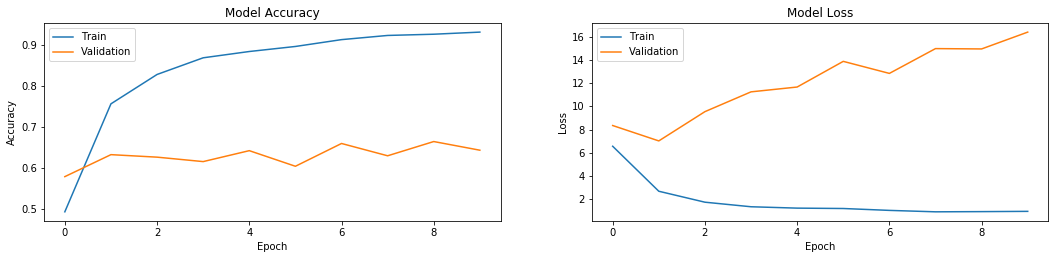

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

## **Xception**

### A1 [10 Epochs] - Training & Validation: [79][57]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 359s 745ms/step - loss: 1.5187 - accuracy: 0.5437 - val_loss: 1.3608 - val_accuracy: 0.5815
Epoch 2/10
481/481 [==============================] - 360s 748ms/step - loss: 1.1007 - accuracy: 0.6497 - val_loss: 1.3128 - val_accuracy: 0.6007
Epoch 3/10
481/481 [==============================] - 356s 741ms/step - loss: 0.9756 - accuracy: 0.6887 - val_loss: 1.3630 - val_accuracy: 0.5874
Epoch 4/10
481/481 [==============================] - 355s 739ms/step - loss: 0.9010 - accuracy: 0.7136 - val_loss: 1.4057 - val_accuracy: 0.5735
Epoch 5/10
481/481 [==============================] - 357s 743ms/step - loss: 0.8378 - accuracy: 0.7351 - val_loss: 1.3883 - val_accuracy: 0.5829
Epoch 6/10
481/481 [==============================] - 357s 742ms/step - loss: 0.7893 - accuracy: 0.7512 - val_loss: 1.4756 - val_accuracy: 0.5677
Epoch 7/10
481/481 [==========

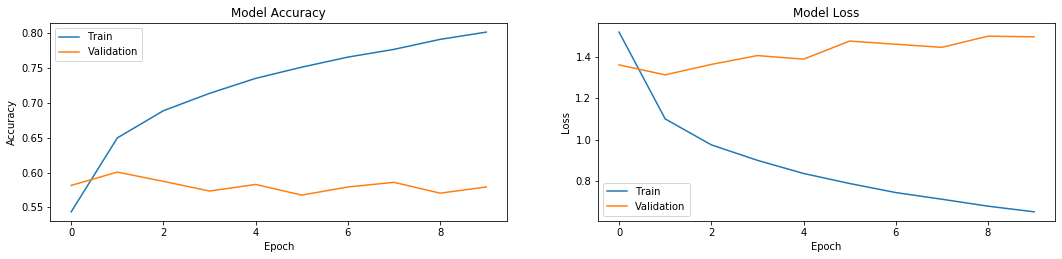

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A2 [10 Epochs][Shuffling] - Training & Validation: [78][66]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)
XModel.save('XModel2.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 409s 849ms/step - loss: 1.5516 - accuracy: 0.5328 - val_loss: 1.2439 - val_accuracy: 0.5984
Epoch 2/10
481/481 [==============================] - 404s 840ms/step - loss: 1.1432 - accuracy: 0.6429 - val_loss: 1.1276 - val_accuracy: 0.6337
Epoch 3/10
481/481 [==============================] - 404s 840ms/step - loss: 1.0280 - accuracy: 0.6775 - val_loss: 1.0887 - val_accuracy: 0.6470
Epoch 4/10
481/481 [==============================] - 403s 838ms/step - loss: 0.9498 - accuracy: 0.6952 - val_loss: 1.0752 - val_accuracy: 0.6445
Epoch 5/10
481/481 [==============================] - 406s 844ms/step - loss: 0.8867 - accuracy: 0.7182 - val_loss: 1.0618 - val_accuracy: 0.6509
Epoch 6/10
481/481 [==============================] - 404s 840ms/step - loss: 0.8380 - accuracy: 0.7350 - val_loss: 1.0760 - val_accuracy: 0.6506
Epoch 7/10
481/481 [==========

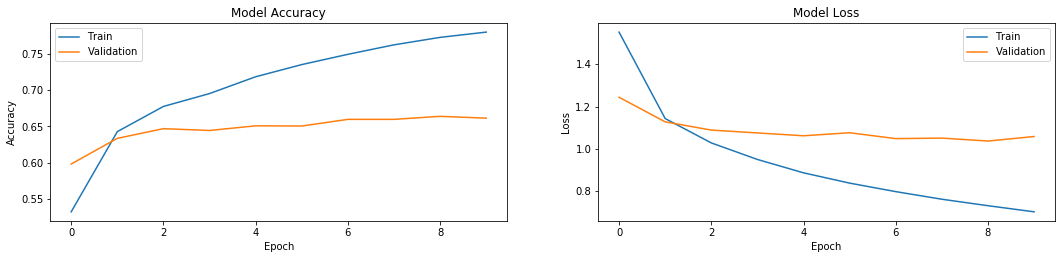

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A3 [10 Epochs][Shuffling][Aug] - Training & Validation: [70][64]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 786s 2s/step - loss: 1.6247 - accuracy: 0.5050 - val_loss: 1.2899 - val_accuracy: 0.5926
Epoch 2/10
481/481 [==============================] - 785s 2s/step - loss: 1.2526 - accuracy: 0.6026 - val_loss: 1.2105 - val_accuracy: 0.6109
Epoch 3/10
481/481 [==============================] - 787s 2s/step - loss: 1.1416 - accuracy: 0.6309 - val_loss: 1.1549 - val_accuracy: 0.6303
Epoch 4/10
481/481 [==============================] - 786s 2s/step - loss: 1.0817 - accuracy: 0.6479 - val_loss: 1.1590 - val_accuracy: 0.6212
Epoch 5/10
481/481 [==============================] - 785s 2s/step - loss: 1.0389 - accuracy: 0.6631 - val_loss: 1.1700 - val_accuracy: 0.6204
Epoch 6/10
481/481 [==============================] - 785s 2s/step - loss: 1.0007 - accuracy: 0.6779 - val_loss: 1.1243 - val_accuracy: 0.6392
Epoch 7/10
481/481 [============================

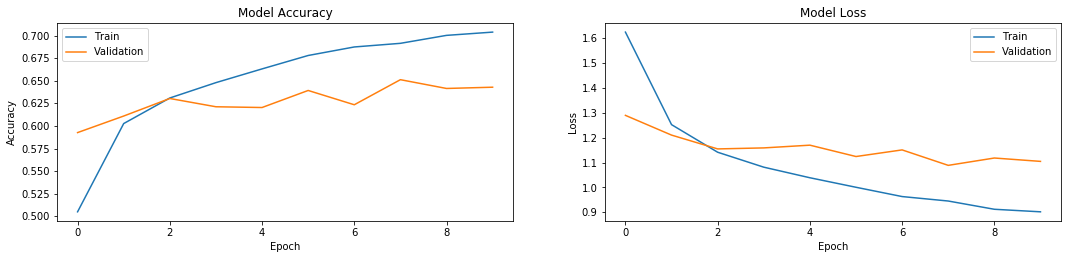

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A4 [10 Epochs][Shuffling][-7] - Training & Validation: [99][74]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 413s 860ms/step - loss: 1.0388 - accuracy: 0.6755 - val_loss: 0.9498 - val_accuracy: 0.6988
Epoch 2/10
481/481 [==============================] - 408s 849ms/step - loss: 0.3023 - accuracy: 0.9057 - val_loss: 1.0094 - val_accuracy: 0.7307
Epoch 3/10
481/481 [==============================] - 407s 847ms/step - loss: 0.0829 - accuracy: 0.9772 - val_loss: 1.0943 - val_accuracy: 0.7454
Epoch 4/10
481/481 [==============================] - 401s 834ms/step - loss: 0.0485 - accuracy: 0.9856 - val_loss: 1.3702 - val_accuracy: 0.7274
Epoch 5/10
481/481 [==============================] - 400s 832ms/step - loss: 0.0885 - accuracy: 0.9694 - val_loss: 1.3519 - val_accuracy: 0.7282
Epoch 6/10
481/481 [==============================] - 400s 831ms/step - loss: 0.0710 - accuracy: 0.9773 - val_loss: 1.5107 - val_accuracy: 0.7188
Epoch 7/10
481/481 [==========

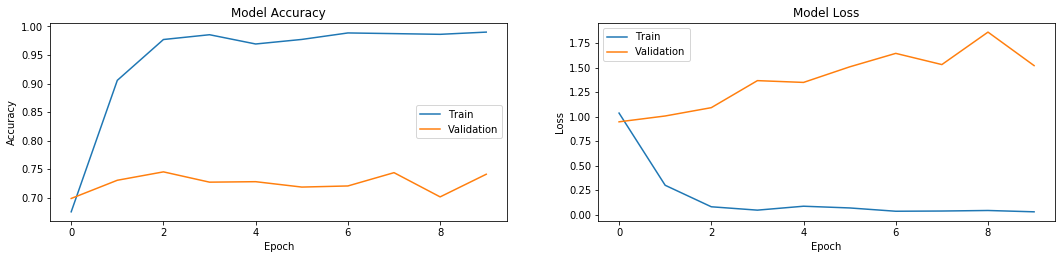

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A5  [10 Epochs][Shuffling][-17] - Training & Validation: [98][70]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Drop     = keras.layers.Dropout(0.5)
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Drop, Flatten, Output ])

for layer in Xception.layers[:-17]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 415s 863ms/step - loss: 1.1245 - accuracy: 0.6516 - val_loss: 1.1069 - val_accuracy: 0.6711
Epoch 2/10
481/481 [==============================] - 407s 846ms/step - loss: 0.5004 - accuracy: 0.8425 - val_loss: 1.3278 - val_accuracy: 0.6547
Epoch 3/10
481/481 [==============================] - 406s 844ms/step - loss: 0.2225 - accuracy: 0.9299 - val_loss: 1.5520 - val_accuracy: 0.6334
Epoch 4/10
481/481 [==============================] - 405s 841ms/step - loss: 0.1220 - accuracy: 0.9587 - val_loss: 1.6112 - val_accuracy: 0.6409
Epoch 5/10
481/481 [==============================] - 405s 842ms/step - loss: 0.1036 - accuracy: 0.9667 - val_loss: 2.1217 - val_accuracy: 0.6229
Epoch 6/10
481/481 [==============================] - 407s 846ms/step - loss: 0.0868 - accuracy: 0.9724 - val_loss: 1.9971 - val_accuracy: 0.6448
Epoch 7/10
481/481 [==========

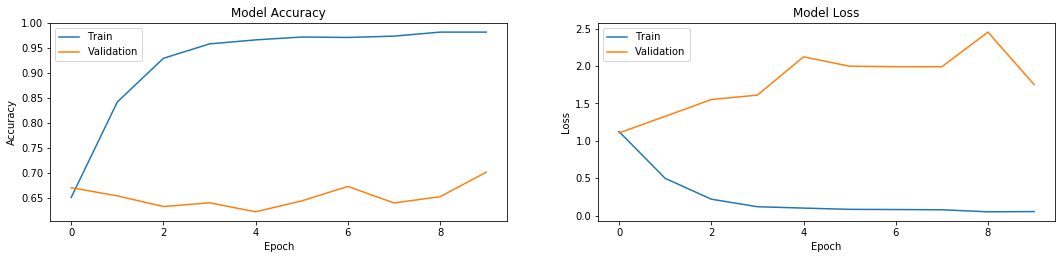

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A6  [10 Epochs][Shuffling][SGD] - Training & Validation: [63][61]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 437s 909ms/step - loss: 2.2248 - accuracy: 0.3498 - val_loss: 1.8683 - val_accuracy: 0.4867
Epoch 2/10
481/481 [==============================] - 433s 900ms/step - loss: 1.7628 - accuracy: 0.5132 - val_loss: 1.6163 - val_accuracy: 0.5549
Epoch 3/10
481/481 [==============================] - 429s 892ms/step - loss: 1.5776 - accuracy: 0.5565 - val_loss: 1.4980 - val_accuracy: 0.5663
Epoch 4/10
481/481 [==============================] - 435s 903ms/step - loss: 1.4730 - accuracy: 0.5767 - val_loss: 1.4279 - val_accuracy: 0.5765
Epoch 5/10
481/481 [==============================] - 432s 899ms/step - loss: 1.4026 - accuracy: 0.5909 - val_loss: 1.3876 - val_accuracy: 0.5921
Epoch 6/10
481/481 [==============================] - 438s 911ms/step - loss: 1.3494 - accuracy: 0.6027 - val_loss: 1.3440 - val_accuracy: 0.5954
Epoch 7/10
481/481 [==========

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A7 [10 Epochs][Shuffling][SGD][+layers] - Training & Validation: [64][62]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
PreOut   = keras.layers.Dense(128, activation="relu")
Drop     = keras.layers.Dropout(0.3)
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, PreOut, Drop, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 469s 975ms/step - loss: 2.3049 - accuracy: 0.3218 - val_loss: 1.8952 - val_accuracy: 0.4648
Epoch 2/10
481/481 [==============================] - 465s 967ms/step - loss: 1.8027 - accuracy: 0.4719 - val_loss: 1.5933 - val_accuracy: 0.5433
Epoch 3/10
481/481 [==============================] - 467s 971ms/step - loss: 1.5853 - accuracy: 0.5278 - val_loss: 1.4617 - val_accuracy: 0.5582
Epoch 4/10
481/481 [==============================] - 464s 964ms/step - loss: 1.4693 - accuracy: 0.5619 - val_loss: 1.3782 - val_accuracy: 0.5790
Epoch 5/10
481/481 [==============================] - 467s 971ms/step - loss: 1.3881 - accuracy: 0.5813 - val_loss: 1.3274 - val_accuracy: 0.5907
Epoch 6/10
481/481 [==============================] - 468s 972ms/step - loss: 1.3328 - accuracy: 0.5903 - val_loss: 1.2727 - val_accuracy: 0.6034
Epoch 7/10
481/481 [==========

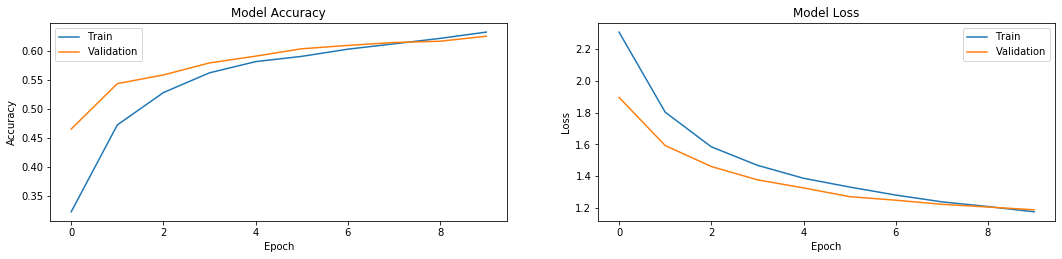

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A8 [10 Epochs][Shuffling][Adamax] - Training & Validation: [69][64]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 464s 966ms/step - loss: 1.8203 - accuracy: 0.4747 - val_loss: 1.4796 - val_accuracy: 0.5596
Epoch 2/10
481/481 [==============================] - 453s 942ms/step - loss: 1.3863 - accuracy: 0.5851 - val_loss: 1.3191 - val_accuracy: 0.5943
Epoch 3/10
481/481 [==============================] - 475s 988ms/step - loss: 1.2531 - accuracy: 0.6169 - val_loss: 1.2574 - val_accuracy: 0.6065
Epoch 4/10
481/481 [==============================] - 446s 928ms/step - loss: 1.1747 - accuracy: 0.6395 - val_loss: 1.1909 - val_accuracy: 0.6262
Epoch 5/10
481/481 [==============================] - 443s 922ms/step - loss: 1.1182 - accuracy: 0.6513 - val_loss: 1.1768 - val_accuracy: 0.6229
Epoch 6/10
481/481 [==============================] - 448s 931ms/step - loss: 1.0732 - accuracy: 0.6633 - val_loss: 1.1513 - val_accuracy: 0.6328
Epoch 7/10
481/481 [==========

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A9 [10 Epochs][Shuffling][Adamax][+layers] - Training & Validation: [73][65]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
PreOut   = keras.layers.Dense(128, activation="relu")
Drop     = keras.layers.Dropout(0.3)
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, PreOut, Drop, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 470s 977ms/step - loss: 1.8082 - accuracy: 0.4667 - val_loss: 1.3648 - val_accuracy: 0.5768
Epoch 2/10
481/481 [==============================] - 466s 970ms/step - loss: 1.3830 - accuracy: 0.5785 - val_loss: 1.2609 - val_accuracy: 0.5932
Epoch 3/10
481/481 [==============================] - 467s 972ms/step - loss: 1.2427 - accuracy: 0.6151 - val_loss: 1.2037 - val_accuracy: 0.6106
Epoch 4/10
481/481 [==============================] - 465s 967ms/step - loss: 1.1527 - accuracy: 0.6410 - val_loss: 1.1697 - val_accuracy: 0.6248
Epoch 5/10
481/481 [==============================] - 468s 973ms/step - loss: 1.0837 - accuracy: 0.6586 - val_loss: 1.1374 - val_accuracy: 0.6287
Epoch 6/10
481/481 [==============================] - 468s 973ms/step - loss: 1.0261 - accuracy: 0.6742 - val_loss: 1.1060 - val_accuracy: 0.6378
Epoch 7/10
481/481 [==========

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

# **7. Parameters Experments**

## **VGG16**

### A2 [30 Epochs][50 Batch][Shuffling][-10][+layers] - Training & Validation: [98][72]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=50, class_mode="sparse", target_size=(224,224))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=50, class_mode="sparse", target_size=(224,224))

In [0]:
vgg16 = VGG16(include_top = False, weights='imagenet', pooling='avg', classes=20)
model_vgg = Sequential()
model_vgg.add(vgg16)
model_vgg.add(keras.layers.Flatten())
model_vgg.add(Dense(512, activation='relu')) 
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(20, activation = 'softmax'))

for layer in vgg16.layers[:-10]:
        layer.trainable = False

adam = Adam(lr=0.0001)
model_vgg.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cb_checkpointer_vgg = ModelCheckpoint(filepath = '../best_vgg.h5', monitor = 'val_loss', save_best_only = True)
fit_history = model_vgg.fit(Training, epochs = 30, validation_data=Validation, callbacks=[cb_checkpointer_vgg])

58892288/58889256 [==============================] - 2s 0us/step
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 73 steps
Epoch 1/30
289/289 [==============================] - 371s 1s/step - loss: 2.2400 - accuracy: 0.3088 - val_loss: 1.8695 - val_accuracy: 0.4163
Epoch 2/30
289/289 [==============================] - 371s 1s/step - loss: 1.7408 - accuracy: 0.4571 - val_loss: 1.4887 - val_accuracy: 0.5391
Epoch 3/30
289/289 [==============================] - 370s 1s/step - loss: 1.4005 - accuracy: 0.5681 - val_loss: 1.2745 - val_accuracy: 0.6104
Epoch 4/30
289/289 [==============================] - 366s 1s/step - loss: 1.1026 - accuracy: 0.6581 - val_loss: 1.2407 - val_accuracy: 0.5971
Epoch 5/30
289/289 [==============================] - 366s 1s/step - loss: 0.8670 - accuracy: 0.7295 - val_loss: 1.0905 - val_accuracy: 0.6744
Epoch 6/30
289/289 [==============================] - 369s 1s/step - loss: 0.6459 - accuracy: 0.8010 - val_loss: 1.0341 - val_a

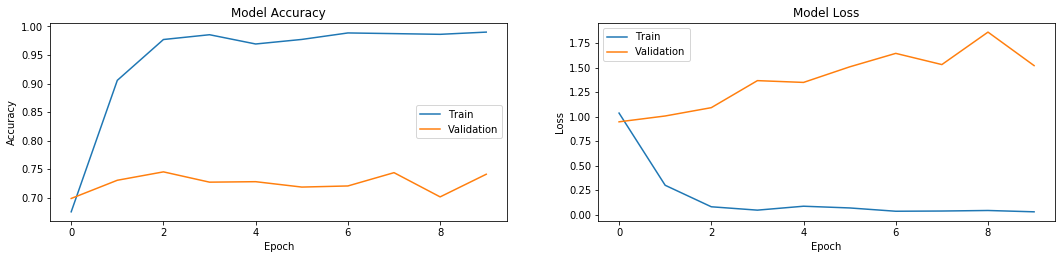

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

## **Xception**

### A10 [30 Epochs][30 Batch][Shuffling][-7] - Training & Validation: [86][67]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 14424 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])
XModel.layers[0].trainable = False
XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], validation_data=Validation)
XModel.save('XModel3.h5')

83689472/83683744 [==============================] - 1s 0us/step
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/30
481/481 [==============================] - 470s 977ms/step - loss: 1.5302 - accuracy: 0.5356 - val_loss: 1.2236 - val_accuracy: 0.6145
Epoch 2/30
481/481 [==============================] - 462s 961ms/step - loss: 1.1324 - accuracy: 0.6433 - val_loss: 1.1344 - val_accuracy: 0.6387
Epoch 3/30
481/481 [==============================] - 464s 964ms/step - loss: 1.0140 - accuracy: 0.6812 - val_loss: 1.0856 - val_accuracy: 0.6547
Epoch 4/30
481/481 [==============================] - 465s 967ms/step - loss: 0.9361 - accuracy: 0.7025 - val_loss: 1.0752 - val_accuracy: 0.6539
Epoch 5/30
481/481 [==============================] - 468s 973ms/step - loss: 0.8750 - accuracy: 0.7224 - val_loss: 1.0361 - val_accuracy: 0.6595
Epoch 6/30
481/481 [==============================] - 468s 973ms/step - loss: 0.8250 - accuracy: 0.7398 - val_l

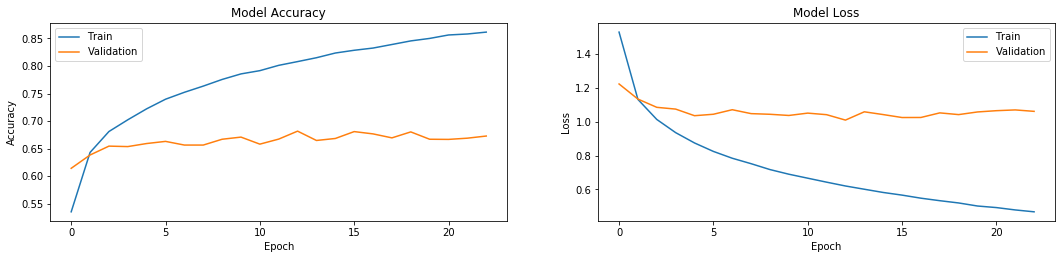

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A11 [30 Epochs][100 Batch][Shuffling][-7] - Training & Validation: [99][80]



In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))

Found 16227 validated image filenames belonging to 20 classes.
Found 1803 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 19 steps
Epoch 1/30
163/163 [==============================] - 418s 3s/step - loss: 1.0045 - accuracy: 0.6927 - val_loss: 0.8396 - val_accuracy: 0.7432
Epoch 2/30
163/163 [==============================] - 418s 3s/step - loss: 0.2841 - accuracy: 0.9212 - val_loss: 0.8570 - val_accuracy: 0.7526
Epoch 3/30
163/163 [==============================] - 419s 3s/step - loss: 0.0631 - accuracy: 0.9866 - val_loss: 0.8401 - val_accuracy: 0.7615
Epoch 4/30
163/163 [==============================] - 418s 3s/step - loss: 0.0158 - accuracy: 0.9972 - val_loss: 0.8354 - val_accuracy: 0.7992
Epoch 5/30
163/163 [==============================] - 414s 3s/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.8902 - val_accuracy: 0.7948
Epoch 6/30
163/163 [==============================] - 416s 3s/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.8322 - val_accuracy: 0.8003
Epoch 7/30
163/163 [=============================

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A12 [30 Epochs][100 Batch][Shuffling][-7][Weights][Nesterov] - Training & Validation: [78][68]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)

Found 16227 validated image filenames belonging to 20 classes.
Found 1803 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
XModel.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], class_weight=class_weights, validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 19 steps
Epoch 1/30
163/163 [==============================] - 391s 2s/step - loss: 2.4326 - accuracy: 0.2680 - val_loss: 2.0448 - val_accuracy: 0.4093
Epoch 2/30
163/163 [==============================] - 378s 2s/step - loss: 1.9385 - accuracy: 0.4590 - val_loss: 1.7073 - val_accuracy: 0.4969
Epoch 3/30
163/163 [==============================] - 374s 2s/step - loss: 1.6778 - accuracy: 0.5320 - val_loss: 1.5315 - val_accuracy: 0.5363
Epoch 4/30
163/163 [==============================] - 376s 2s/step - loss: 1.5195 - accuracy: 0.5651 - val_loss: 1.4383 - val_accuracy: 0.5535
Epoch 5/30
163/163 [==============================] - 379s 2s/step - loss: 1.4154 - accuracy: 0.5888 - val_loss: 1.3741 - val_accuracy: 0.5740
Epoch 6/30
163/163 [==============================] - 374s 2s/step - loss: 1.3410 - accuracy: 0.6055 - val_loss: 1.3288 - val_accuracy: 0.5862
Epoch 7/30
163/163 [=============================

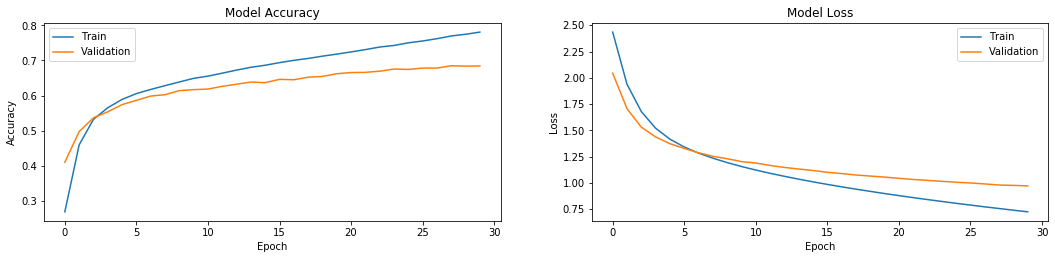

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A13 (30 Epochs][100 Batch][Shuffling][-47][Weights][Nesterov] - Training & Validation: [99][71]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)

Found 16227 validated image filenames belonging to 20 classes.
Found 1803 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-47]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.0015, momentum=0.95, nesterov=True)
XModel.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], class_weight=class_weights, validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 19 steps
Epoch 1/30
163/163 [==============================] - 381s 2s/step - loss: 2.0385 - accuracy: 0.4068 - val_loss: 1.4760 - val_accuracy: 0.5702
Epoch 2/30
163/163 [==============================] - 355s 2s/step - loss: 1.2853 - accuracy: 0.6137 - val_loss: 1.2155 - val_accuracy: 0.6062
Epoch 3/30
163/163 [==============================] - 350s 2s/step - loss: 1.0439 - accuracy: 0.6739 - val_loss: 1.0855 - val_accuracy: 0.6500
Epoch 4/30
163/163 [==============================] - 347s 2s/step - loss: 0.8764 - accuracy: 0.7309 - val_loss: 1.0136 - val_accuracy: 0.6694
Epoch 5/30
163/163 [==============================] - 350s 2s/step - loss: 0.7404 - accuracy: 0.7764 - val_loss: 0.9594 - val_accuracy: 0.6805
Epoch 6/30
163/163 [==============================] - 351s 2s/step - loss: 0.6222 - accuracy: 0.8161 - val_loss: 0.9314 - val_accuracy: 0.6933
Epoch 7/30
163/163 [=============================

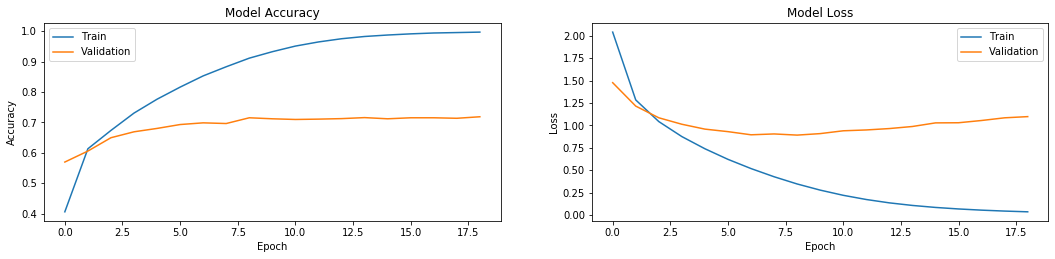

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

### A14 [30 Epochs][100 Batch][Shuffling][-47] - Training & Validation: [100][81]

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DF.shape, "Testing Data: ", Test_DF.shape

Found 16227 validated image filenames belonging to 20 classes.
Found 1803 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 4), 'Testing Data: ', (6908, 4))

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

for layer in Xception.layers[:-47]:
    layer.trainable = False

XModelxx = tf.keras.Sequential([ Xception, Flatten, Output ])

XModelxx.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModelxx.fit(Training, epochs=30, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 19 steps
Epoch 1/30
163/163 [==============================] - 437s 3s/step - loss: 0.9707 - accuracy: 0.6999 - val_loss: 1.0415 - val_accuracy: 0.6606
Epoch 2/30
163/163 [==============================] - 425s 3s/step - loss: 0.2658 - accuracy: 0.9205 - val_loss: 1.0226 - val_accuracy: 0.7016
Epoch 3/30
163/163 [==============================] - 421s 3s/step - loss: 0.0750 - accuracy: 0.9783 - val_loss: 0.9927 - val_accuracy: 0.7598
Epoch 4/30
163/163 [==============================] - 416s 3s/step - loss: 0.0375 - accuracy: 0.9900 - val_loss: 1.0557 - val_accuracy: 0.7532
Epoch 5/30
163/163 [==============================] - 413s 3s/step - loss: 0.0520 - accuracy: 0.9833 - val_loss: 1.3697 - val_accuracy: 0.7099
Epoch 6/30
163/163 [==============================] - 412s 3s/step - loss: 0.1429 - accuracy: 0.9543 - val_loss: 1.2296 - val_accuracy: 0.6922
Epoch 7/30
163/163 [=============================

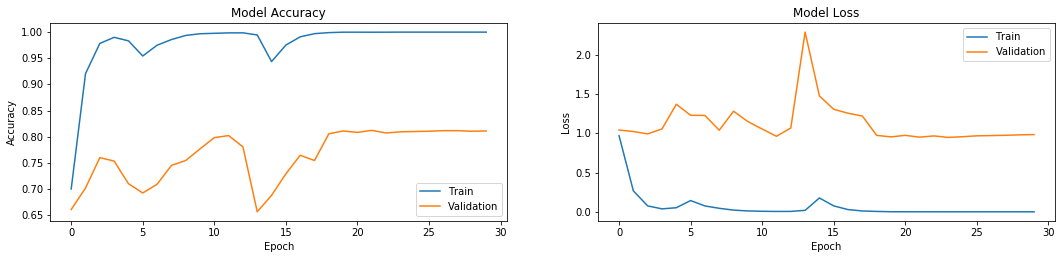

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

# **8. Additional Experment**
**1. Augmenting Images and Saving them**

In [0]:
Train_DF = DF[DF['Train'] == 1].dropna().reset_index(drop=True)[:-30]
allimages = os.listdir('images')
for i in range(len(Train_DF)):
  if (Train_DF.Image[i] not in allimages):
    Train_DF = Train_DF.drop(i)

datagen = ImageDataGenerator()
Training   = datagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", batch_size=100, shuffle=False, class_mode="sparse", target_size=(299,299))
aug = ImageDataGenerator(rotation_range=30, zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, fill_mode="nearest")
!mkdir aug
z, tepoch, Errors = 0, 100, 0
for i in range(180):
  x, total = 1, 100
  imageGen = aug.flow(Training[i], batch_size=1, shuffle=False, save_to_dir= "/content/aug", save_format="jpg")
  for image in imageGen:
    if (x==total or len(os.listdir('aug')) == z + tepoch):
      break
    x = x + 1
  if (len(os.listdir('aug')) != z + tepoch):
    for image in imageGen:
      Errors = Errors + 1
      if (len(os.listdir('aug')) == z + tepoch):
        break
  z = z + tepoch
print("Saved ", len(os.listdir('aug')), " augmented images with ", Errors, " corrected errors.")

Found 18000 validated image filenames belonging to 20 classes.
Saved  18000  augmented images with  180  corrected errors.


**2. Sorting them time based, becase keras generate random names**

In [0]:
search_dir = "/content/aug/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join("aug/", f) for f in files] # add path to each file
os.chdir("/content/")
files.sort(key=lambda x: os.path.getmtime(x))
len(files)

18000

**3. Adding the Augmented images + Orignal images to one Dataframe to train '36000' Image**

In [0]:
Aug_DF = pd.DataFrame(index=range(0,len(Train_DF)),columns=['Category','Activity','Train'])
Aug_DF.insert(loc=0, column='Image', value=pd.Series(files))
Aug_DF['Category'], Aug_DF['Activity'], Aug_DF['Train'] = Train_DF['Category'].values, Train_DF['Activity'].values, Train_DF['Train'].values
Total_DF = Train_DF.reset_index(drop=True)
for i in range(len(Train_DF)):
  Total_DF.Image[i] = str("images/"+str(Train_DF.Image.reset_index(drop=True)[i]))
Total_DF = Total_DF.append(Aug_DF).reset_index(drop=True).dropna()
Total_DF = Total_DF.sample(frac=1).reset_index(drop=True)

datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Total_DF, directory=None, x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Total_DF, directory=None, x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)

Found 28800 validated image filenames belonging to 20 classes.
Found 7200 validated image filenames belonging to 20 classes.


- **Original Images**

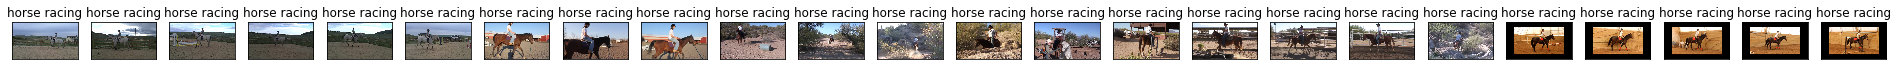

In [0]:
dimentions = 1
plt.subplots(figsize=(35,25))
for i in range(3):
  for i in range(17976,len(Total_DF.Image)):
    if dimentions == 25: break
    cur_img = mpimg.imread("/content/"+Total_DF.Image[i])
    ax = plt.subplot(1, 25, dimentions)
    ax.set_xticks([]), ax.set_yticks([])
    plt.title(Total_DF.Activity[i])
    plt.imshow(cur_img)
    dimentions += 1

- **Augmented Images:**

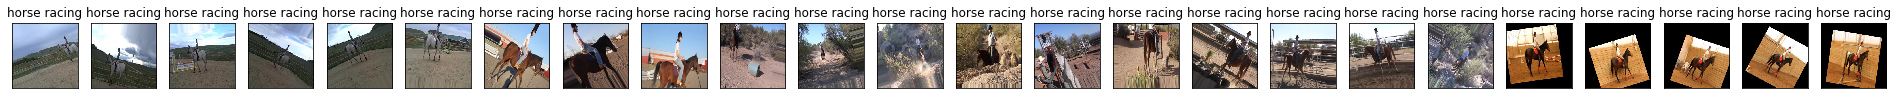

In [0]:
dimentions = 1
plt.subplots(figsize=(35,25))
for i in range(3):
  for i in range(17976,len(Aug_DF.Image)):
    if dimentions == 25: break
    cur_img = mpimg.imread(Aug_DF.Image[i])
    ax = plt.subplot(1, 25, dimentions)
    ax.set_xticks([]), ax.set_yticks([])
    plt.title(Aug_DF.Activity[i])
    plt.imshow(cur_img)
    dimentions += 1

**4. Training**

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], validation_data=Validation)

83689472/83683744 [==============================] - 1s 0us/step
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 288 steps, validate for 72 steps
Epoch 1/30
288/288 [==============================] - 452s 2s/step - loss: 1.8155 - accuracy: 0.4491 - val_loss: 1.8703 - val_accuracy: 0.4326
Epoch 2/30
288/288 [==============================] - 404s 1s/step - loss: 1.1057 - accuracy: 0.6557 - val_loss: 1.8195 - val_accuracy: 0.4453
Epoch 3/30
288/288 [==============================] - 398s 1s/step - loss: 0.5317 - accuracy: 0.8383 - val_loss: 2.1706 - val_accuracy: 0.4387
Epoch 4/30
288/288 [==============================] - 399s 1s/step - loss: 0.1774 - accuracy: 0.9533 - val_loss: 2.4451 - val_accuracy: 0.4322
Epoch 5/30
288/288 [==============================] - 398s 1s/step - loss: 0.0799 - accuracy: 0.9809 - val_loss: 2.8782 - val_accuracy: 0.4435
Epoch 6/30
288/288 [==============================] - 396s 1s/step - loss: 0.0407 - accuracy: 0.9918 - val_loss: 3.0485 - val_a

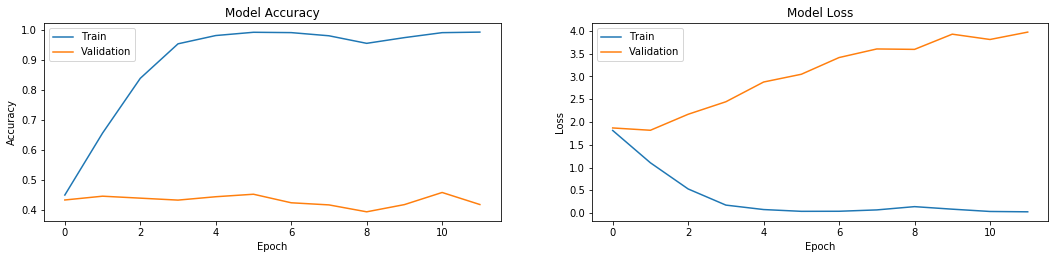

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

# **9. Testing**

### Testing No.1
Xception | 30 Epochs | 100 Batch | Adam | -7

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)

PRC = int(0.2 * len(Train_DF))
Train_DF, Test_DF = Train_DF[PRC:].reset_index(drop=True), Train_DF[:PRC].reset_index(drop=True)

trdatagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing   = tsdatagen.flow_from_dataframe(dataframe = Test_DF, directory="/content/images", x_col="Image", y_col="Category", batch_size=1, class_mode="sparse", target_size=(299,299))

class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)
len(Train_DF), " Training & Validation Data, ", len(Test_DF), " Test Data"

Found 13631 validated image filenames belonging to 20 classes.
Found 1514 validated image filenames belonging to 20 classes.
Found 2885 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


(15148, ' Training & Validation Data, ', 2885, ' Test Data')

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], class_weight=class_weights, validation_data=Validation)

83689472/83683744 [==============================] - 1s 0us/step
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 130 steps, validate for 15 steps
Epoch 1/30
130/130 [==============================] - 358s 3s/step - loss: 1.0874 - accuracy: 0.6619 - val_loss: 0.9053 - val_accuracy: 0.7212
Epoch 2/30
130/130 [==============================] - 329s 3s/step - loss: 0.3006 - accuracy: 0.9152 - val_loss: 0.8270 - val_accuracy: 0.7531
Epoch 3/30
130/130 [==============================] - 320s 2s/step - loss: 0.0623 - accuracy: 0.9894 - val_loss: 0.8315 - val_accuracy: 0.7517
Epoch 4/30
130/130 [==============================] - 321s 2s/step - loss: 0.0158 - accuracy: 0.9973 - val_loss: 0.8425 - val_accuracy: 0.7788
Epoch 5/30
130/130 [==============================] - 320s 2s/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.8274 - val_accuracy: 0.7850
Epoch 6/30
130/130 [==============================] - 322s 2s/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.8472 - val_a

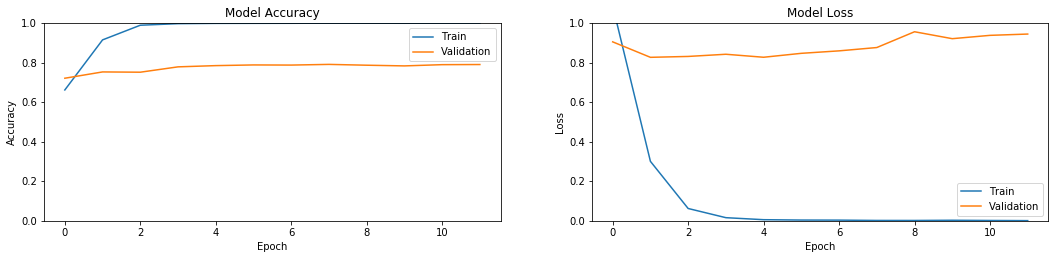

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)

plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)
XModel.save('XModelTest1.h5')
plt.show()

In [0]:
Results = XModel.evaluate_generator(generator=Testing)
print('Loss: ', round(Results[0], 3), '\nAccuracy:', round(Results[1], 3))

Loss:  0.512 
Accuracy: 0.835


### Testing No.2
Xception | 30 Epochs | 100 Batch | Neterov | -47

In [0]:
PRC = int(0.2 * len(Train_DF))
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
Train_DF, Test_DF = Train_DF[PRC:].reset_index(drop=True), Train_DF[:PRC].reset_index(drop=True)

trdatagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing   = tsdatagen.flow_from_dataframe(dataframe = Test_DF, directory="/content/images", x_col="Image", y_col="Category", batch_size=1, class_mode="sparse", target_size=(299,299))

class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)
len(Train_DF), " Training & Validation Data, ", len(Test_DF), " Test Data"

Found 13522 validated image filenames belonging to 20 classes.
Found 1502 validated image filenames belonging to 20 classes.
Found 3006 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


(15027, ' Training & Validation Data, ', 3006, ' Test Data')

In [0]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=20)
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(20, activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-47]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.0015, momentum=0.95, nesterov=True)
XModel.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], class_weight=class_weights, validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 136 steps, validate for 16 steps
Epoch 1/30
136/136 [==============================] - 365s 3s/step - loss: 2.1641 - accuracy: 0.3772 - val_loss: 1.5868 - val_accuracy: 0.5399
Epoch 2/30
136/136 [==============================] - 365s 3s/step - loss: 1.3854 - accuracy: 0.5895 - val_loss: 1.2679 - val_accuracy: 0.5899
Epoch 3/30
136/136 [==============================] - 365s 3s/step - loss: 1.1216 - accuracy: 0.6560 - val_loss: 1.1465 - val_accuracy: 0.6198
Epoch 4/30
136/136 [==============================] - 363s 3s/step - loss: 0.9525 - accuracy: 0.7040 - val_loss: 1.0504 - val_accuracy: 0.6538
Epoch 5/30
136/136 [==============================] - 363s 3s/step - loss: 0.8137 - accuracy: 0.7488 - val_loss: 0.9878 - val_accuracy: 0.6678
Epoch 6/30
136/136 [==============================] - 363s 3s/step - loss: 0.6963 - accuracy: 0.7898 - val_loss: 0.9496 - val_accuracy: 0.6798
Epoch 7/30
136/136 [=============================

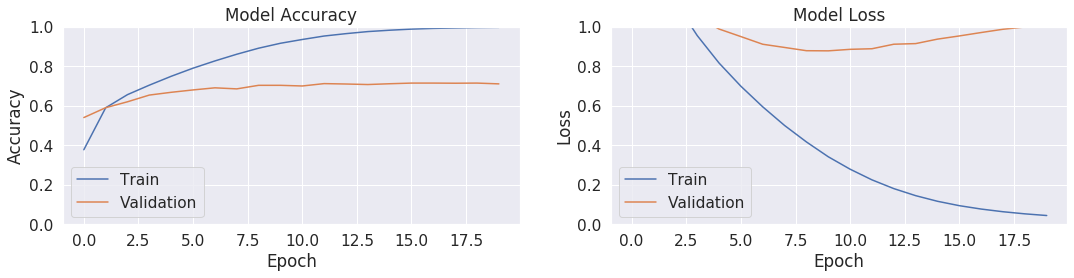

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)

plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)
XModel.save('XModelTest2.h5')
plt.show()

In [0]:
Results = XModel.evaluate_generator(generator=Testing)
print('Loss: ', round(Results[0], 3), '\nAccuracy:', round(Results[1], 3))

Loss:  0.852 
Accuracy: 0.729


### Testing No. 3
InceptionResNetV2 | 10 Epochs | 100 Batch | SGD 

In [0]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
PRC = int(0.2 * len(Train_DF))

Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)
Train_DF, Test_DF = Train_DF[PRC:].reset_index(drop=True), Train_DF[:PRC].reset_index(drop=True)

trdatagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Category", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing   = tsdatagen.flow_from_dataframe(dataframe = Test_DF, directory="/content/images", x_col="Image", y_col="Category", batch_size=1, class_mode="sparse", target_size=(299,299))

class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)
len(Train_DF), " Training & Validation Data, ", len(Test_DF), " Test Data"

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 12982 validated image filenames belonging to 20 classes.
Found 1442 validated image filenames belonging to 20 classes.
Found 3606 validated image filenames belonging to 20 classes.


(14427, ' Training & Validation Data, ', 3606, ' Test Data')

In [0]:
NUM_CLASSES = len(Act_DF)   #class/Labels
print(NUM_CLASSES)
inceptionAct100 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=None,input_shape=[299,299,3], classes=NUM_CLASSES)
Flatten  = keras.layers.Flatten()
Dropout = keras.layers.Dropout(0.5)
OutputAct100   = keras.layers.Dense(NUM_CLASSES, activation="softmax")

IRNV2Act100Model = tf.keras.Sequential([ inceptionAct100, Flatten, Dropout,OutputAct100  ])
IRNV2Act100Model.layers[0].trainable = False
IRNV2Act100Model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = IRNV2Act100Model.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)

IRNV2Act100Model.save('IRNV2Act100SDGModel70.h5')

397
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 130 steps, validate for 15 steps
Epoch 1/10
130/130 [==============================] - 359s 3s/step - loss: 7.2005 - accuracy: 0.4114 - val_loss: 4.8966 - val_accuracy: 0.5326
Epoch 2/10
130/130 [==============================] - 315s 2s/step - loss: 2.2856 - accuracy: 0.6461 - val_loss: 2.9791 - val_accuracy: 0.6415
Epoch 3/10
130/130 [==============================] - 306s 2s/step - loss: 1.2753 - accuracy: 0.7574 - val_loss: 2.3169 - val_accuracy: 0.6540
Epoch 4/10
130/130 [==============================] - 303s 2s/step - loss: 0.6250 - accuracy: 0.8519 - val_loss: 2.0340 - val_accuracy: 0.6706
Epoch 5/10
130/130 [==============================] - 302s 2s/step - loss: 0.4496 - accuracy: 0.8950 - val_loss: 2.1197 - val_accuracy: 0.6734
Epoch 6/10
130/130 [==============================] - 301s 2s/step - loss: 0.1733 - accuracy: 0.9450 - val_loss: 2.8523 - val_accuracy: 0.5985
Epoch 7/10
130/130 [=========================

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_8 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 397)               39027085  
Total params: 93,363,821
Trainable params: 39,027,085
Non-trainable params: 54,336,736
_________________________________________________________________


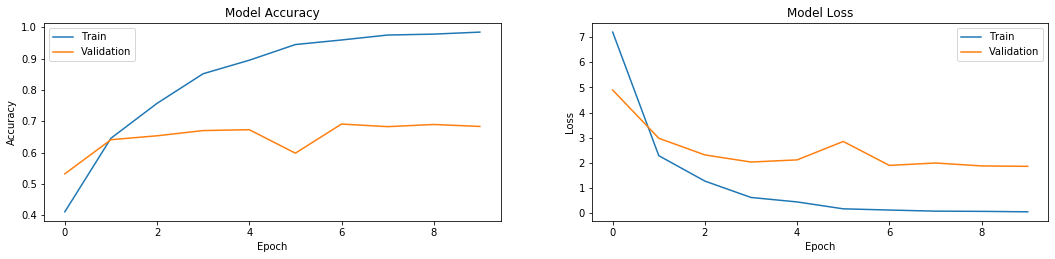

In [0]:
IRNV2Act100Model.summary()
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

In [0]:
ResultsAct100 = IRNV2Act100Model.evaluate_generator(generator=Testing)
print('Loss: ', round(ResultsAct100[0], 3), '\nAccuracy:', round(ResultsAct100[1], 3))

  ...
    to  
  ['...']
Loss:  1.958 
Accuracy: 0.672


# **10. Bonus Part**

### Trial 1
InceptionResNetV2 | 10 Epochs | 30 Batch | Adam

In [0]:
Train_DFAct, Test_DFAct = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DFAct = Train_DFAct.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training   = datagen.flow_from_dataframe(dataframe = Train_DFAct, directory="/content/images", x_col="Image", y_col="Activity", subset="training", batch_size=30, class_mode="sparse", target_size=(299,299))
Validation = datagen.flow_from_dataframe(dataframe = Train_DFAct, directory="/content/images", x_col="Image", y_col="Activity", subset="validation", batch_size=30, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DFAct.shape, "Testing Data: ", Test_DFAct.shape

Found 14424 validated image filenames belonging to 397 classes.
Found 3606 validated image filenames belonging to 397 classes.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 5), 'Testing Data: ', (6908, 5))

In [0]:
NUM_CLASSES = len(Act_DF)   #class/Labels
print(NUM_CLASSES)
inceptionAct = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=None,input_shape=[299,299,3], classes=NUM_CLASSES)
Flatten  = keras.layers.Flatten()
Dropout = keras.layers.Dropout(0.5)
OutputAct   = keras.layers.Dense(NUM_CLASSES, activation="softmax")

IRNV2ActModel = tf.keras.Sequential([ inceptionAct, Flatten, Dropout,OutputAct  ])
IRNV2ActModel.layers[0].trainable = False
IRNV2ActModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = IRNV2ActModel.fit(Training, epochs=10, callbacks=[callback], validation_data=Validation)
IRNV2ActModel.save('IRNV2ActModel.h5')

397
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 481 steps, validate for 121 steps
Epoch 1/10
481/481 [==============================] - 444s 923ms/step - loss: 18.8768 - accuracy: 0.3236 - val_loss: 24.5233 - val_accuracy: 0.4129
Epoch 2/10
481/481 [==============================] - 407s 846ms/step - loss: 2.2579 - accuracy: 0.8645 - val_loss: 23.9130 - val_accuracy: 0.4351
Epoch 3/10
481/481 [==============================] - 396s 824ms/step - loss: 1.7286 - accuracy: 0.8967 - val_loss: 26.9586 - val_accuracy: 0.4445
Epoch 4/10
481/481 [==============================] - 396s 823ms/step - loss: 1.5778 - accuracy: 0.9108 - val_loss: 28.3849 - val_accuracy: 0.4615
Epoch 5/10
481/481 [==============================] - 395s 822ms/step - loss: 1.3844 - accuracy: 0.9257 - val_loss: 33.8223 - val_accuracy: 0.4362
Epoch 6/10
481/481 [==============================] - 392s 814ms/step - loss: 1.6759 - accuracy: 0.9215 - val_loss: 34.2184 - val_accuracy: 0.4659
Epoch 7/10
481/481 

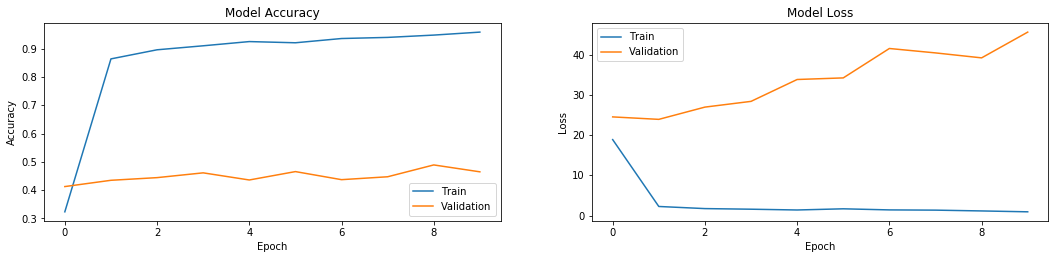

In [0]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()


### Testing No.1
InceptionResNetV2 | 10 Epochs | 100 Batch | Adam

In [0]:
Train_DFAct100, Test_DFAct100 = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DFAct100 = Train_DFAct100.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training100   = datagen.flow_from_dataframe(dataframe = Train_DFAct100, directory="/content/images", x_col="Image", y_col="Activity", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation100 = datagen.flow_from_dataframe(dataframe = Train_DFAct100, directory="/content/images", x_col="Image", y_col="Activity", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DFAct100.shape, "Testing Data: ", Test_DFAct100.shape


Found 14424 validated image filenames belonging to 397 classes.
Found 3606 validated image filenames belonging to 397 classes.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 5), 'Testing Data: ', (6908, 5))

In [0]:
NUM_CLASSES = len(Act_DF)   #class/Labels
print(NUM_CLASSES)
inceptionAct100 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=None,input_shape=[299,299,3], classes=NUM_CLASSES)
Flatten  = keras.layers.Flatten()
Dropout = keras.layers.Dropout(0.5)
OutputAct100   = keras.layers.Dense(NUM_CLASSES, activation="softmax")

IRNV2Act100Model = tf.keras.Sequential([ inceptionAct100, Flatten, Dropout,OutputAct100  ])
IRNV2Act100Model.layers[0].trainable = False
IRNV2Act100Model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = IRNV2Act100Model.fit(Training100, epochs=10, callbacks=[callback], validation_data=Validation100)
IRNV2Act100Model.save('IRNV2Act100Model.h5')

397
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 145 steps, validate for 37 steps
Epoch 1/10
145/145 [==============================] - 379s 3s/step - loss: 13.8755 - accuracy: 0.3433 - val_loss: 12.0541 - val_accuracy: 0.4603
Epoch 2/10
145/145 [==============================] - 359s 2s/step - loss: 1.2411 - accuracy: 0.8712 - val_loss: 13.0795 - val_accuracy: 0.4695
Epoch 3/10
145/145 [==============================] - 351s 2s/step - loss: 0.6166 - accuracy: 0.9282 - val_loss: 12.5021 - val_accuracy: 0.4892
Epoch 4/10
145/145 [==============================] - 352s 2s/step - loss: 0.5145 - accuracy: 0.9403 - val_loss: 13.6978 - val_accuracy: 0.4875
Epoch 5/10
145/145 [==============================] - 353s 2s/step - loss: 0.4359 - accuracy: 0.9503 - val_loss: 13.3547 - val_accuracy: 0.5050
Epoch 6/10
145/145 [==============================] - 356s 2s/step - loss: 0.4697 - accuracy: 0.9486 - val_loss: 16.7902 - val_accuracy: 0.4534
Epoch 7/10
145/145 [==================

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 397)               39027085  
Total params: 93,363,821
Trainable params: 39,027,085
Non-trainable params: 54,336,736
_________________________________________________________________


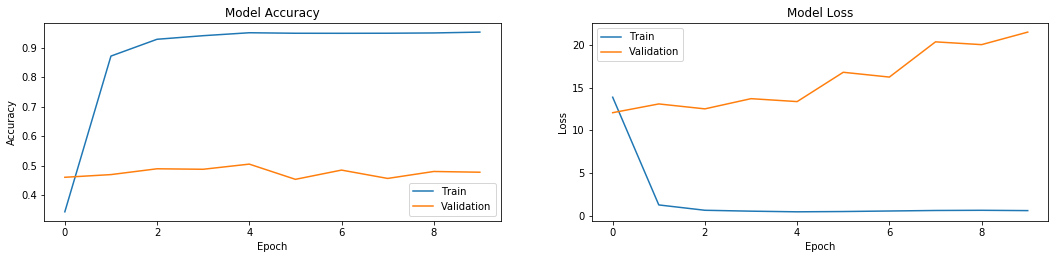

In [0]:
IRNV2Act100Model.summary()
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

In [0]:
# TESTING DATA
Test_DFAct100withoutNA = Test_DFAct100[~Test_DFAct100['Activity'].isna()]
print('Test_DFAct100withoutNA',Test_DFAct100withoutNA.shape)

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing100   = tsdatagen.flow_from_dataframe(dataframe = Test_DFAct100withoutNA, directory="/content/images", x_col="Image", y_col="Activity", batch_size=1, class_mode="sparse", target_size=(299,299))

ResultsAct100 = IRNV2Act100Model.evaluate_generator(generator=Testing100)
print('Loss: ', round(ResultsAct100[0], 3), '\nAccuracy:', round(ResultsAct100[1], 3))

Test_DFAct100withoutNA (1, 5)
Found 1 validated image filenames belonging to 1 classes.
  ...
    to  
  ['...']
Loss:  98.181 
Accuracy: 0.0


### Testing No.2
InceptionResNetV2 | 10 Epochs | 30 Batch | SGD

In [0]:
Train_DFAct100, Test_DFAct100 = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DFAct100 = Train_DFAct100.sample(frac=1).reset_index(drop=True)
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
Training100   = datagen.flow_from_dataframe(dataframe = Train_DFAct100, directory="/content/images", x_col="Image", y_col="Activity", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation100 = datagen.flow_from_dataframe(dataframe = Train_DFAct100, directory="/content/images", x_col="Image", y_col="Activity", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))
"Training Data: ", Train_DFAct100.shape, "Testing Data: ", Test_DFAct100.shape


Found 14424 validated image filenames belonging to 397 classes.
Found 3606 validated image filenames belonging to 397 classes.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


('Training Data: ', (18033, 5), 'Testing Data: ', (6908, 5))

In [0]:
NUM_CLASSES = len(Act_DF)   #class/Labels
print(NUM_CLASSES)
inceptionAct100 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=None,input_shape=[299,299,3], classes=NUM_CLASSES)
Flatten  = keras.layers.Flatten()
Dropout = keras.layers.Dropout(0.5)
OutputAct100   = keras.layers.Dense(NUM_CLASSES, activation="softmax")

IRNV2Act100Model = tf.keras.Sequential([ inceptionAct100, Flatten, Dropout,OutputAct100  ])
IRNV2Act100Model.layers[0].trainable = False
IRNV2Act100Model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = IRNV2Act100Model.fit(Training100, epochs=10, callbacks=[callback], validation_data=Validation100)
IRNV2Act100Model.save('IRNV2Act100SDGModel.h5')


397
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 145 steps, validate for 37 steps
Epoch 1/10
145/145 [==============================] - 366s 3s/step - loss: 4.1438 - accuracy: 0.2686 - val_loss: 2.5536 - val_accuracy: 0.4587
Epoch 2/10
145/145 [==============================] - 348s 2s/step - loss: 1.1639 - accuracy: 0.7390 - val_loss: 2.1988 - val_accuracy: 0.5086
Epoch 3/10
145/145 [==============================] - 351s 2s/step - loss: 0.4280 - accuracy: 0.9248 - val_loss: 2.0224 - val_accuracy: 0.5397
Epoch 4/10
145/145 [==============================] - 354s 2s/step - loss: 0.2081 - accuracy: 0.9747 - val_loss: 1.9839 - val_accuracy: 0.5532
Epoch 5/10
145/145 [==============================] - 350s 2s/step - loss: 0.1247 - accuracy: 0.9899 - val_loss: 1.9556 - val_accuracy: 0.5588
Epoch 6/10
145/145 [==============================] - 349s 2s/step - loss: 0.0881 - accuracy: 0.9947 - val_loss: 1.9617 - val_accuracy: 0.5602
Epoch 7/10
145/145 [=========================

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_4 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 397)               39027085  
Total params: 93,363,821
Trainable params: 39,027,085
Non-trainable params: 54,336,736
_________________________________________________________________


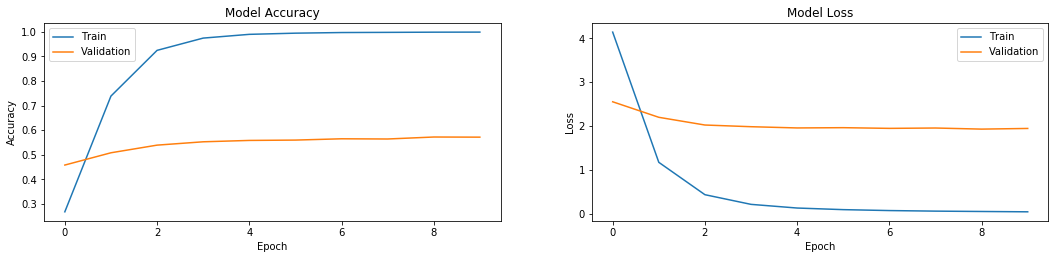

In [0]:
IRNV2Act100Model.summary()
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 

plt.show()

In [0]:
# TESTING DATA
Test_DFAct100withoutNA = Test_DFAct100[~Test_DFAct100['Activity'].isna()]
print('Test_DFAct100withoutNA',Test_DFAct100withoutNA.shape)

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing100   = tsdatagen.flow_from_dataframe(dataframe = Test_DFAct100withoutNA, directory="/content/images", x_col="Image", y_col="Activity", batch_size=1, class_mode="sparse", target_size=(299,299))

ResultsAct100 = IRNV2Act100Model.evaluate_generator(generator=Testing100)
print('Loss: ', round(ResultsAct100[0], 3), '\nAccuracy:', round(ResultsAct100[1], 3))



Test_DFAct100withoutNA (1, 5)
Found 1 validated image filenames belonging to 1 classes.
  ...
    to  
  ['...']
Loss:  9.471 
Accuracy: 0.0


### Testing No.3
Xception | 30 Epochs | 100 Batch | Adam

In [15]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)

PRC = int(0.2 * len(Train_DF))
Train_DF, Test_DF = Train_DF[PRC:].reset_index(drop=True), Train_DF[:PRC].reset_index(drop=True)

trdatagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Activity", subset="training", batch_size=100, class_mode="sparse", target_size=(299,299))
Validation = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Activity", subset="validation", batch_size=100, class_mode="sparse", target_size=(299,299))

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing   = tsdatagen.flow_from_dataframe(dataframe = Test_DF, directory="/content/images", x_col="Image", y_col="Activity", batch_size=1, class_mode="sparse", target_size=(299,299))

class_weights = class_weight.compute_class_weight('balanced', np.unique(Training.classes), Training.classes)
len(Train_DF), " Training & Validation Data, ", len(Test_DF), " Test Data"

Found 12983 validated image filenames belonging to 396 classes.
Found 1442 validated image filenames belonging to 396 classes.
Found 3605 validated image filenames belonging to 375 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


(14427, ' Training & Validation Data, ', 3606, ' Test Data')

In [9]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=len(np.unique(Training.classes)))
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(len(np.unique(Training.classes)), activation="softmax")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], class_weight=class_weights, validation_data=Validation)

130/130 [==============================] - 346s 3s/step - loss: 3.0770 - accuracy: 0.4078 - val_loss: 1.8037 - val_accuracy: 0.5624
Epoch 2/30
130/130 [==============================] - 320s 2s/step - loss: 0.7574 - accuracy: 0.8382 - val_loss: 1.4386 - val_accuracy: 0.6553
Epoch 3/30
130/130 [==============================] - 315s 2s/step - loss: 0.1575 - accuracy: 0.9770 - val_loss: 1.2810 - val_accuracy: 0.6956
Epoch 4/30
130/130 [==============================] - 318s 2s/step - loss: 0.0366 - accuracy: 0.9961 - val_loss: 1.2470 - val_accuracy: 0.7108
Epoch 5/30
130/130 [==============================] - 316s 2s/step - loss: 0.0206 - accuracy: 0.9971 - val_loss: 1.2065 - val_accuracy: 0.7240
Epoch 6/30
130/130 [==============================] - 318s 2s/step - loss: 0.0101 - accuracy: 0.9983 - val_loss: 1.2024 - val_accuracy: 0.7233
Epoch 7/30
130/130 [==============================] - 316s 2s/step - loss: 0.0061 - accuracy: 0.9995 - val_loss: 1.2044 - val_accuracy: 0.7282
Epoch 8/30

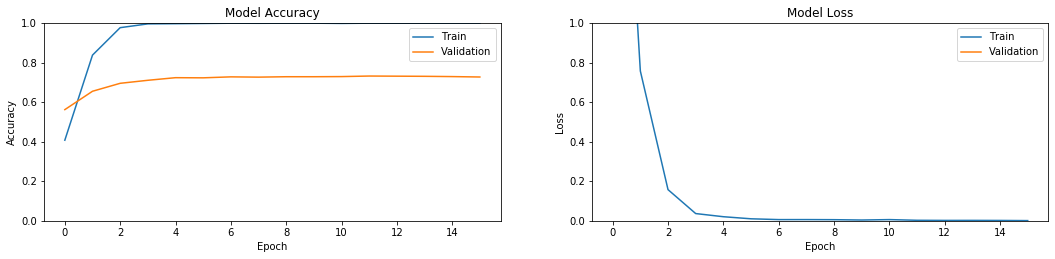

In [16]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)

plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)
XModel.save('XModelBonus1.h5')
plt.show()

In [17]:
Results = XModel.evaluate_generator(generator=Testing)
print('Loss: ', round(Results[0], 3), '\nAccuracy:', round(Results[1], 3))

Loss:  11.651 
Accuracy: 0.177


### Testing No.3 [Multi-Output Classification]
Xception | 30 Epochs | 100 Batch | Adam

In [73]:
Train_DF, Test_DF = DF[DF['Train'] == 1].dropna(), DF[DF['Train'] == 0]
Train_DF = Train_DF.sample(frac=1).reset_index(drop=True)

for i in range(len(Train_DF)):
  Train_DF.Activity[i] = Train_DF.Activity[i].split(',')

PRC = int(0.2 * len(Train_DF))
Train_DF, Test_DF = Train_DF[PRC:].reset_index(drop=True), Train_DF[:PRC].reset_index(drop=True)

trdatagen = ImageDataGenerator(rescale=1./255., validation_split=0.10)
Training   = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Activity", subset="training", batch_size=100, class_mode="categorical", target_size=(299,299))
Validation = trdatagen.flow_from_dataframe(dataframe = Train_DF, directory="/content/images", x_col="Image", y_col="Activity", subset="validation", batch_size=100, class_mode="categorical", target_size=(299,299))

tsdatagen = ImageDataGenerator(rescale=1./255.)
Testing   = tsdatagen.flow_from_dataframe(dataframe = Test_DF, directory="/content/images", x_col="Image", y_col="Activity", batch_size=1, class_mode="categorical", target_size=(299,299))
len(Train_DF), " Training & Validation Data, ", len(Test_DF), " Test Data"

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 12982 validated image filenames belonging to 646 classes.
Found 1442 validated image filenames belonging to 646 classes.
Found 3606 validated image filenames belonging to 610 classes.


(14427, ' Training & Validation Data, ', 3606, ' Test Data')

In [61]:
Xception = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', classes=len(Training.class_indices))
Flatten  = keras.layers.Flatten()
Output   = keras.layers.Dense(len(Training.class_indices), activation="sigmoid")

XModel = tf.keras.Sequential([ Xception, Flatten, Output ])

for layer in Xception.layers[:-7]:
    layer.trainable = False

XModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = XModel.fit(Training, epochs=30, callbacks=[callback], validation_data=Validation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 130 steps, validate for 15 steps
Epoch 1/30
130/130 [==============================] - 322s 2s/step - loss: 8.1580 - accuracy: 0.1148 - val_loss: 6.3102 - val_accuracy: 0.2184
Epoch 2/30
130/130 [==============================] - 312s 2s/step - loss: 3.5737 - accuracy: 0.4319 - val_loss: 5.5740 - val_accuracy: 0.3322
Epoch 3/30
130/130 [==============================] - 304s 2s/step - loss: 2.3332 - accuracy: 0.5758 - val_loss: 4.8468 - val_accuracy: 0.3634
Epoch 4/30
130/130 [==============================] - 310s 2s/step - loss: 2.0422 - accuracy: 0.6164 - val_loss: 4.6547 - val_accuracy: 0.3807
Epoch 5/30
130/130 [==============================] - 315s 2s/step - loss: 1.9300 - accuracy: 0.6153 - val_loss: 5.0491 - val_accuracy: 0.3620
Epoch 6/30
130/130 [==============================] - 316s 2s/step - loss: 1.8689 - accuracy: 0.6179 - val_loss: 4.7492 - val_accuracy: 0.4092
Epoch 7/30
130/130 [=============================

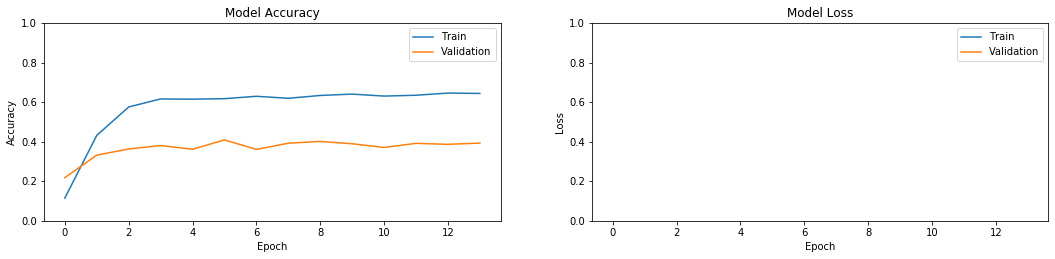

In [62]:
plt.figure(1, figsize = (18,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)

plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation']) 
plt.gca().set_ylim(0, 1)
XModel.save('XModelBonus1.h5')
plt.show()

In [0]:
Results = XModel.predict_generator(generator=Testing)

Result saved in a variable, because testing data will not have all 646 Class to be able to evaluate the model, but with about 40% Val.Accuracy is a reasonable result due to the limited amount of data given that there are 600+ Classes, the Model did not fed enough images to train on and classify correctly.